# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [19]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic

from Timer import Timer

import logging

In [20]:
import pytest
from ipytest import run_pytest,clean_tests

In [21]:
%setup_logging
%cuda_context_handler context

Global logger already initialized!
Registering context in user workspace
Context already registered! Ignoring


In [22]:
cuda_kernel = """
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [46]:
def gpuMatrixVector(a,b):
    context.synchronize()
    
    
    with Timer("DataAlloc", logging.INFO) as t:
        #Upload data to the device
        #NOTE: We need to make sure that a=(a_rows, a_columns)
        # and that b=(a_colmuns, 1) (column vector)
        # and that c=(a_rows, 1)
        a_g = GPUArray(a.shape, np.float32)
        b_g = GPUArray(b.shape, np.float32)
        a_g.set(a)
        b_g.set(b)

    #Allocate output data
    c_g = GPUArray(a.shape[0], np.float32)
    context.synchronize()

    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (128, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / 128)), 1, 1)

   # print("Block size is " + str(block_size))
    #print("Grid size is " + str(grid_size))

    with Timer("KernelExec", logging.INFO) as t:
        #Execute program on device
        kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)

        context.synchronize() # test functions are asynchronous

     #Copy data from device to host
    c = np.empty((a.shape[0],1),dtype = np.float32)
    c_g.get(c)

    #Return our computed matrix-vector product
    return c

In [40]:
nx = np.array([200, 400, 800, 1600, 3200, 6400])
ny = nx

In [48]:
times = np.empty_like(nx)

for i in range(len(nx)):
    
    print(nx[i])
    
    #Size of our test
    test_size = (nx[i], ny[i])

    with Timer("DataCreation", logging.INFO) as t:

        #Create test input / output data
        a = np.random.random(test_size).astype(np.float32)
        b = np.random.random((test_size[1], 1)).astype(np.float32)

    with Timer("DataComputation", logging.INFO) as t:

        c = gpuMatrixVector(a,b)
        
    times[i] = t.msecs
    
    
    

DataCreation: 6.364346 ms
DataAlloc: 0.750065 ms
KernelExec: 0.482798 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
DataComputation: 4.473448 ms
DataCreation: 2.076864 ms
DataAlloc: 0.654936 ms
KernelExec: 0.396729 ms
DataComputation: 3.656387 ms
DataCreation: 7.878780 ms
DataAlloc: 1.163244 ms
KernelExec: 0.715494 ms
DataComputation: 4.707336 ms
DataCreation: 31.889915 ms
DataAlloc: 2.113581 ms
KernelExec: 1.360655 ms
DataComputation: 6.731510 ms


200
400
800
1600
3200


DataCreation: 185.444117 ms
DataAlloc: 6.697655 ms
KernelExec: 3.538132 ms
DataComputation: 17.826319 ms


6400


DataCreation: 712.697983 ms
DataAlloc: 22.525549 ms
KernelExec: 13.279438 ms
DataComputation: 58.935642 ms


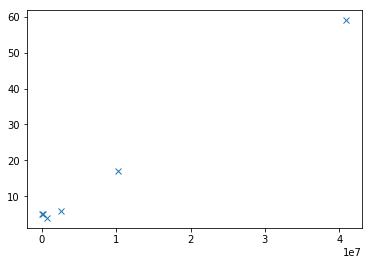

In [43]:
plt.figure()
plt.plot(nx*ny, times, 'x')

DataCreation: 0.063896 ms
DataAlloc: 1.505613 ms
KernelExec: 0.130892 ms
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
DataComputation: 4.417419 ms
/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


It took 6.389617919921875e-05 seconds
It took 0.0015056133270263672 seconds
Block size is (128, 1, 1)
Grid size is (1, 1, 1)
It took 0.0001308917999267578 seconds
It took 0.00441741943359375 seconds


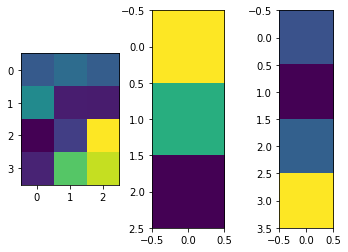

In [28]:
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

In [29]:
with Timer("SadComputation", logging.INFO) as t:
    #Compute reference using Numpy
    c_ref = np.dot(a, b)

    #Sum of absolute differences
    sad = np.sum(np.abs(c - c_ref))
    
print("It took " + str(t.secs) + " seconds")

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)

print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

SadComputation: 0.077009 ms


It took 7.700920104980469e-05 seconds
Sad = 0.000000000000000000000000000000
Per element error: 0.0


In [ ]:
clean_tests()

def test_gpuMatrixVector():
    #Let us test a matrix of size 1x1
    a = np.ones((1,1),dtype = np.float32)
    b = 2*np.ones((1,1),dtype = np.float32)
    c = gpuMatrixVector(a,b)
    assert c == pytest.approx(2.0)
    
    #Test that inner porduct works
    a = np.ones((1,2),dtype = np.float32)
    b = 2*np.ones((2,1),dtype = np.float32)
    c = gpuMatrixVector(a,b)
    assert c == pytest.approx(4.0)
    
    #Test a general matrix
    test_size = (4, 3)

    #Create test input / output data
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = gpuMatrixVector(a,b)
    assert c == pytest.approx(np.dot(a,b))
    assert c == pytest.approx(a.dot(b),rel=1e-3)
    
with Timer("TestComputation", logging.INFO) as t:
    
    run_pytest(filename='MatrixVectorTesting.ipynb',pytest_options=['-vvv'])
    
print("It took " + str(t.secs) + " seconds")


In [ ]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)